In [15]:
import pandas as pd
import pytz
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from breaths import *

***Preprocessing***

In [16]:
# Data Cleaning
# 1. Noise removal:- dual-threshold approach atm 0.1Hz - 1.5Hz

RESPECK_FILE = '../../data/bishkek_csr/03_train_ready/respeck/24-04-2025_respeck.csv'
PSG_FILE = '../../data/bishkek_csr/03_train_ready/nasal_files/24-04-2025_nasal.csv'
LABELS_FILE = '../../data/bishkek_csr/03_train_ready/event_exports/24-04-2025_event_export.csv'

# --- Load Data ---
print("Loading data...")

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# respeck_df.set_index('timestamp', inplace=True)

psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# labels_df.set_index('timestamp', inplace=True)

Loading data...


In [17]:
# Only use overalapping data

start_time_respeck = respeck_df['timestamp'].min()
end_time_respeck = respeck_df['timestamp'].max()

start_time_psg = psg_df['timestamp'].min()
end_time_psg = psg_df['timestamp'].max()

overlap_start = max(start_time_respeck, start_time_psg)
overlap_end = min(end_time_respeck, end_time_psg)

print(overlap_start)
print(overlap_end)

respeck_df = respeck_df[(respeck_df['timestamp'] >= overlap_start) & (respeck_df['timestamp'] <= overlap_end)]
psg_df = psg_df[(psg_df['timestamp'] >= overlap_start) & (psg_df['timestamp'] <= overlap_end)]


2025-04-24 00:03:34+06:00
2025-04-24 06:01:27.990000+06:00


In [18]:

# respeck_df.set_index('timestamp', inplace=True)
# Calculate the sampling frequency (fs)
time_diffs = respeck_df.index.to_series().diff().dt.total_seconds()
fs = 1 / time_diffs.median()
print(f"\nDetected Sampling Frequency (fs): {fs:.2f} Hz")

# 3. Define representative segments to analyze
# We'll define the start times for a few 5-minute windows.
# We'll pick a few times from the beginning, middle, and end of the recording.
if not respeck_df.empty:
    segment_starts = [
        respeck_df.index[0] + pd.Timedelta(minutes=5),       # 5 minutes into the recording
        respeck_df.index[0] + pd.Timedelta(minutes=60),      # 60 minutes into the recording
        respeck_df.index[-1] - pd.Timedelta(minutes=10)      # 10 minutes before the end
    ]
    segment_duration = pd.Timedelta(minutes=5)

    # 4. Loop through each segment, compute PSD, and plot
    for i, start_time in enumerate(segment_starts):
        # Select the 5-minute data segment
        end_time = start_time + segment_duration
        segment = respeck_df[start_time:end_time]

        if segment.empty:
            print(f"\nSegment {i+1} starting at {start_time} is empty or too short. Skipping.")
            continue

        # Create a plot for the segment
        plt.figure(figsize=(12, 7))

        # Compute and plot PSD for each axis (x, y, z)
        for axis in ['x', 'y', 'z']:
            # welch returns frequencies and power spectral density
            # nperseg defines the length of each segment for FFT, a larger value gives better frequency resolution
            # We'll use 4 seconds of data for each FFT window (fs * 4)
            frequencies, power = welch(segment[axis], fs=fs, nperseg=fs*4)

            # Use a logarithmic scale for the power axis (semilogy) to see both large and small peaks
            plt.semilogy(frequencies, power, label=f'{axis}-axis')

        plt.title(f'Power Spectral Density (PSD) - Segment {i+1}\n(Start: {start_time.strftime("%H:%M:%S")})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency ($unit^2/Hz$)')
        plt.grid(True, which='both', linestyle='--')
        plt.legend()
        # Limit x-axis to a reasonable range to see details. Frequencies above 2Hz are less common for body movements.
        plt.xlim(0, 2)
        plt.ylim(10e-9, 10e-3) # Set y-axis limits for better comparison between plots
        plt.show()
else:
    print("The DataFrame is empty after loading. Cannot proceed with analysis.")

AttributeError: Can only use .dt accessor with datetimelike values

In [14]:
# frequencies for OSA

apnea_events = labels_df[labels_df['Event'] == 'Obstructive Apnea'].copy()
if not apnea_events.empty:
    # Calculate sampling frequency from the main dataframe
    time_diffs = respeck_df.index.to_series().diff().dt.total_seconds()
    fs = 1 / time_diffs.median()
    print(f"Using detected sampling frequency of {fs:.2f} Hz.")

    for i, event in apnea_events.iterrows():
        start_time = event['timestamp']


        # Extract the signal segment from the main dataframe
        analysis_window_start = start_time - pd.Timedelta(minutes=2.5)
        analysis_window_end = start_time + pd.Timedelta(minutes=2.5)
        
        # Extract the signal segment from the main dataframe using the new window
        segment = respeck_df.loc[analysis_window_start:analysis_window_end]
        
        # Check if the segment is long enough for analysis
        # welch needs at least 2 segments, nperseg should be <= len(segment)
        if segment.shape[0] < fs*2: 
            print(f"\nSkipping event at {start_time.time()} - duration is too short for analysis.")
            continue

        # Create a plot for the segment
        plt.figure(figsize=(12, 7))
        
        # Compute and plot PSD for each axis
        for axis in ['x', 'y', 'z']:
            # nperseg is the segment length for FFT. We can use the length of our event data or a fixed window.
            # It must be <= the length of the segment.
            nperseg = min(segment.shape[0], int(fs * 4)) # Use 4-second window or less if event is shorter
            frequencies, power = welch(segment[axis], fs=fs, nperseg=nperseg)
            plt.semilogy(frequencies, power, label=f'{axis}-axis', alpha=0.8)
        
        plt.title(f'PSD during Obstructive Apnea Event\n(Event Start: {start_time.strftime("%H:%M:%S")})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency ($unit^2/Hz$)')
        plt.grid(True, which='both', linestyle='--')
        plt.legend()
        plt.xlim(0, 2) # Focus on frequencies relevant to body movement/breathing
        plt.tight_layout()
        
        plt.show()

else:
    print("\nNo 'Obstructive Apnea' events were found in the provided labels data.")


AttributeError: Can only use .dt accessor with datetimelike values

In [6]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    """
    Applies a zero-phase Butterworth bandpass filter to the data.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    # The butter function returns the filter coefficients (numerator b, denominator a)
    b, a = butter(order, [low, high], btype='band')
    # filtfilt applies the filter forward and backward, resulting in zero phase shift
    y = filtfilt(b, a, data)
    return y


# Based on graph 0.1-0.8Hz
LOWCUT = 0.1  
HIGHCUT = 1.5

FILTER_ORDER = 4

# --- 6. Visualization for Verification ---

print("Generating plot for verification...")

# Define a time vector for the x-axis of the plot
respeck_df['time_seconds'] = respeck_df['alignedTimestamp'] / 1000.0

# Choose a 60-second segment to visualize
sampling_period = respeck_df['time_seconds'].diff().median()
FS = 1.0 / sampling_period

start_index = 1000
end_index = start_index + int(60 * FS) # 60 seconds of data


print(f"Calculated Sampling Period: {sampling_period:.4f} s")
print(f"Calculated Sampling Frequency (Fs): {FS:.2f} Hz") # Should be close to 12.5 Hz

# Recommended: Calculate the vector magnitude of the accelerometer signal
# This creates a single signal that is robust to sensor orientation.

print("Calculating vector magnitude from x, y, z axes...")
accel_mag = np.sqrt(respeck_df['x']**2 + respeck_df['y']**2 + respeck_df['z']**2)
accel_mag_detrended = accel_mag - accel_mag.mean()

print(f"Applying {LOWCUT}-{HIGHCUT}Hz bandpass filter...")

filtered_breathing_signal = butter_bandpass_filter(
    data=accel_mag_detrended.values, 
    lowcut=LOWCUT, 
    highcut=HIGHCUT, 
    fs=FS, 
    order=FILTER_ORDER
)

respeck_df['breathing_signal_filtered'] = filtered_breathing_signal
print("Added 'breathing_signal_filtered' column to the DataFrame.")

Generating plot for verification...
Calculated Sampling Period: 0.0800 s
Calculated Sampling Frequency (Fs): 12.50 Hz
Calculating vector magnitude from x, y, z axes...
Applying 0.1-1.5Hz bandpass filter...
Added 'breathing_signal_filtered' column to the DataFrame.


Generating plot for verification...


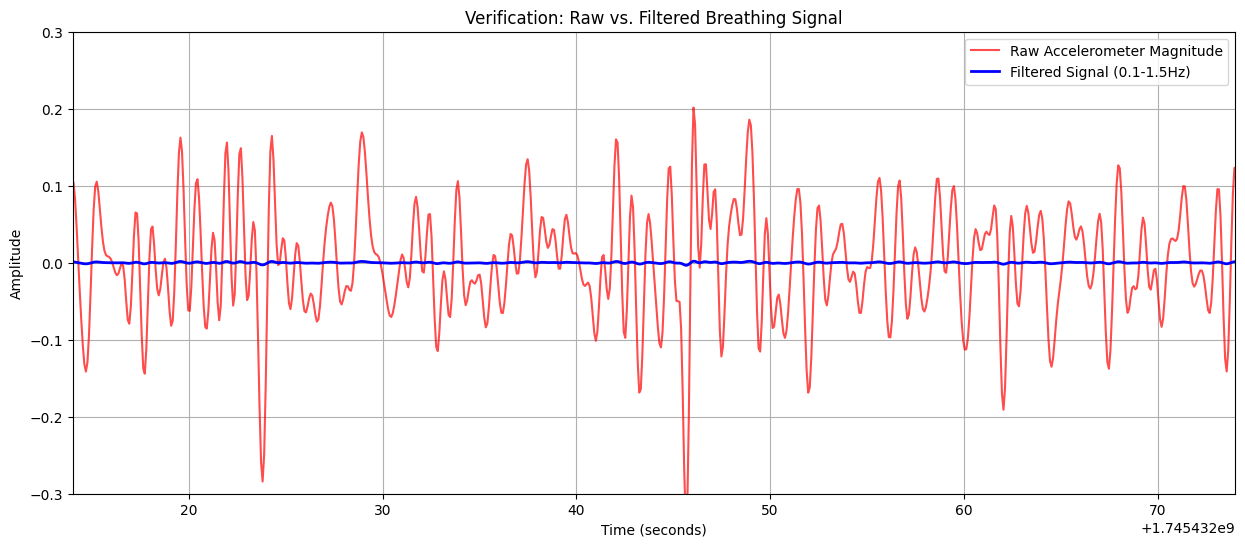

In [10]:
print("Generating plot for verification...")

# Choose a 60-second segment to visualize
# We'll plot from 10 minutes (600s) to 11 minutes (660s) into the recording
start_time_plot = respeck_df['time_seconds'].iloc[0] + 600
end_time_plot = start_time_plot + 60

plt.figure(figsize=(15, 6))

#Use the 'time_seconds' column directly for the x-axis
plt.plot(respeck_df['time_seconds'],
         respeck_df['breathingSignal'],
         label='Raw Accelerometer Magnitude',
         color='red',
         alpha=0.7)

plt.plot(respeck_df['time_seconds'],
         respeck_df['breathing_signal_filtered'],
         label=f'Filtered Signal ({LOWCUT}-{HIGHCUT}Hz)',
         color='blue',
         linewidth=2)

# Set the plot limits to our desired time window
plt.xlim(start_time_plot, end_time_plot)
plt.ylim(-0.3,0.3)
plt.title('Verification: Raw vs. Filtered Breathing Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(getBreaths(respeck_df))

Uses Breath From 43032/268795 = 16.01% Signal
Max Breath Length: 151 points. Min Breath Length: 5 points
[[191, 228, 268, 302, 359, 393, 415, 447, 479, 576, 603, 644, 697, 734, 768, 796], [1073, 1110, 1144, 1178, 1206, 1225, 1269, 1366, 1387, 1482, 1564, 1591, 1642, 1680, 1701, 1738, 1773, 1805, 1837, 1873, 1901, 1921, 1927, 1954, 1973, 2063, 2101, 2150, 2185, 2225, 2266, 2303, 2391, 2429, 2471, 2489], [3798, 3830, 3862, 3894, 3920, 3944, 3965], [4866], [5347, 5369, 5419, 5440, 5479, 5522, 5548, 5555, 5563, 5591, 5616, 5652, 5681, 5709, 5736, 5766, 5798, 5820, 5845, 5880, 5907, 5953, 5985, 6023, 6039, 6096, 6128, 6169, 6210, 6250], [9321], [9735, 9774, 9834, 9850, 9880, 9992, 10031, 10064, 10127, 10159, 10221, 10267, 10304, 10368, 10372, 10408, 10435, 10478, 10521, 10540, 10607, 10652, 10678, 10749], [10856, 10890, 10940, 10995, 11044, 11075, 11113, 11142, 11173, 11191, 11245, 11279, 11308, 11341, 11376], [12107, 12148, 12187, 12227, 12291, 12335, 12372, 12407, 12444], [15307, 15348, 1

In [ ]:
# Extract Features
breath_features = extractFeatures(respeck_df)
print(breath_features)

In [ ]:
features_df = combineDfs(breath_features, respeck_df)

In [ ]:
print(features_df.columns)

In [ ]:
breath_regularity_feature = compute_breath_regularity(features_df)

In [ ]:
print(breath_regularity_feature)

In [ ]:
breath_regularity_feature.to_csv('26-04-2025_respeck_features.csv')